# Moving average strategy backtest example

- An example moving average strategy using the [exponential moving average (EMA) indicator](https://tradingstrategy.ai/glossary/ema), using 1h candles on Binance
- When the fast ema crosses above the slow ema, we buy. Conversely, when the fast ema crosses below the slow ema, we sell
- We don't use a stop loss here, but you can easily add one if you want, just uncomment one line in `decide_trades`. In this case, we allow the market enough room to breathe so that trends develop


# Set up

Set up Trading Strategy data client.

In [18]:
from tradeexecutor.utils.notebook import setup_charting_and_output
from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Strategy parameters define the fixed and grid searched parameters

In [19]:
from tradingstrategy.chain import ChainId
import datetime

from tradeexecutor.strategy.default_routing_options import TradeRouting
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters


class Parameters:
    """Parameteres for this strategy.

    - Collect parameters used for this strategy here

    - Both live trading and backtesting parameters
    """

    id = "eth-moving-average" # Used in cache paths

    cycle_duration = CycleDuration.cycle_1h  # Run decide_trades() every 1h
    candle_time_bucket = TimeBucket.h1  # Which OHLCV candle time frame we use
    allocation = 0.98   # Cash allocation per open position, 98% per all cash

    fast_ema = 15 * 24  # Length 
    slow_ema = 30 * 24

    required_history_period = datetime.timedelta(days=slow_ema+1)
    backtest_start = datetime.datetime(2019, 1, 1)
    backtest_end = datetime.datetime(2024, 4, 27)

    stop_loss_time_bucket = TimeBucket.m15  # use 15 minute close as the stop loss signal
    backtest_trading_fee = 0.0005 
    initial_cash = 10_000

parameters = StrategyParameters.from_class(Parameters) 


# Trading pairs and market data

- Set up our trading pairs
- Load historical market data for backtesting
- We use Binance CEX data so we have longer history to backtest

In [20]:
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data
from tradingstrategy.client import Client
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.utils.binance import create_binance_universe
from tradeexecutor.strategy.universe_model import UniverseOptions

# List of trading pairs we use in the backtest
# In this backtest, we use Binance data as it has more price history than DEXes
trading_pairs = [
    (ChainId.centralised_exchange, "binance", "ETH", "USDT"),
]

def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - For live trading, we load DEX data

    - We backtest with Binance data, as it has more history
    """

    # Backtesting - load Binance data
    strategy_universe = create_binance_universe(
        [f"{p[2]}{p[3]}" for p in trading_pairs],
        candle_time_bucket=Parameters.candle_time_bucket,
        # stop_loss_time_bucket=Parameters.stop_loss_time_bucket,
        start_at=universe_options.start_at,
        end_at=universe_options.end_at,
        trading_fee_override=Parameters.backtest_trading_fee,
    )
    return strategy_universe


strategy_universe = create_trading_universe(
    None,
    client,
    notebook_execution_context,
    UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
)

# Indicators

- We use `pandas_ta` Python package to calculate technical indicators
- Create the indicators we use in this strategy
- We use RSI and Bollinger band indicators

In [21]:
import pandas_ta

from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse


def create_indicators(
    timestamp: datetime.datetime | None,
    parameters: Parameters,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    indicators = IndicatorSet()

    indicators.add(
        "fast_ema",
        pandas_ta.ema,
        {"length": parameters.fast_ema}
    )

    indicators.add(
        "slow_ema",
        pandas_ta.ema,
        {"length": parameters.slow_ema}
    )

    return indicators

# Trading algorithm

- Describe out trading strategy as code

In [22]:
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput
from tradeexecutor.utils.crossover import contains_cross_over, contains_cross_under
import pandas as pd

def decide_trades(
    input: StrategyInput,
) -> list[TradeExecution]:

    # 
    # Decision cycle setup.
    # Read all variables we are going to use for the decisions.
    #
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    pair = strategy_universe.get_single_pair()
    cash = position_manager.get_current_cash()

    #
    # Indicators
    #

    fast_ema = indicators.get_indicator_value("fast_ema")
    slow_ema = indicators.get_indicator_value("slow_ema")

    if None in (fast_ema, slow_ema):
        # Early start of the backtest,
        # not enough data yet so cannot make decisions
        return []

    trades = []

    if not position_manager.is_any_open():
        # No open positions, decide if BUY in this cycle.
        # We buy the fast ema crosses above the slow ema.
        if fast_ema > slow_ema:
            buy_amount = cash * parameters.allocation
            trades += position_manager.open_1x_long(
                pair, 
                buy_amount, 
                # stop_loss_pct=parameters.stop_loss
            )
    else:
        # We have an open position, decide if SELL in this cycle.
        # We close the position when fast ema crosses under the slow ema.
        if fast_ema < slow_ema:
            trades += position_manager.close_all()

    if input.is_visualisation_enabled():
        visualisation = state.visualisation  # Helper class to visualise strategy output

        # Draw fast ema and slow ema on the price chart
        visualisation.plot_indicator(timestamp, "fast_ema", PlotKind.technical_indicator_on_price, fast_ema, colour="orange")
        visualisation.plot_indicator(timestamp, "slow_ema", PlotKind.technical_indicator_on_price, slow_ema, colour="blue")

    return trades  # Return the list of trades we made in this cycle

# Backtest

- Run the backtest

In [23]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline

state, _, diagnostics_data = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    strategy_logging=False,
)

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Reading cached indicators fast_ema, slow_ema for 1 pairs, using 8 threads:   0%|          | 0/2 [00:00<?, ?it/…

Using indicator cache /Users/moo/.cache/indicators/centralised-exchange_1h_ETH-USDT_2019-01-01-2024-04-27


  0%|          | 0/167875200 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 38 trades


# Equity curve

- Equity curve shows how your strategy accrues value over time
- A good equity curve has a stable ascending angle
- Benchmark against ETH buy and hold

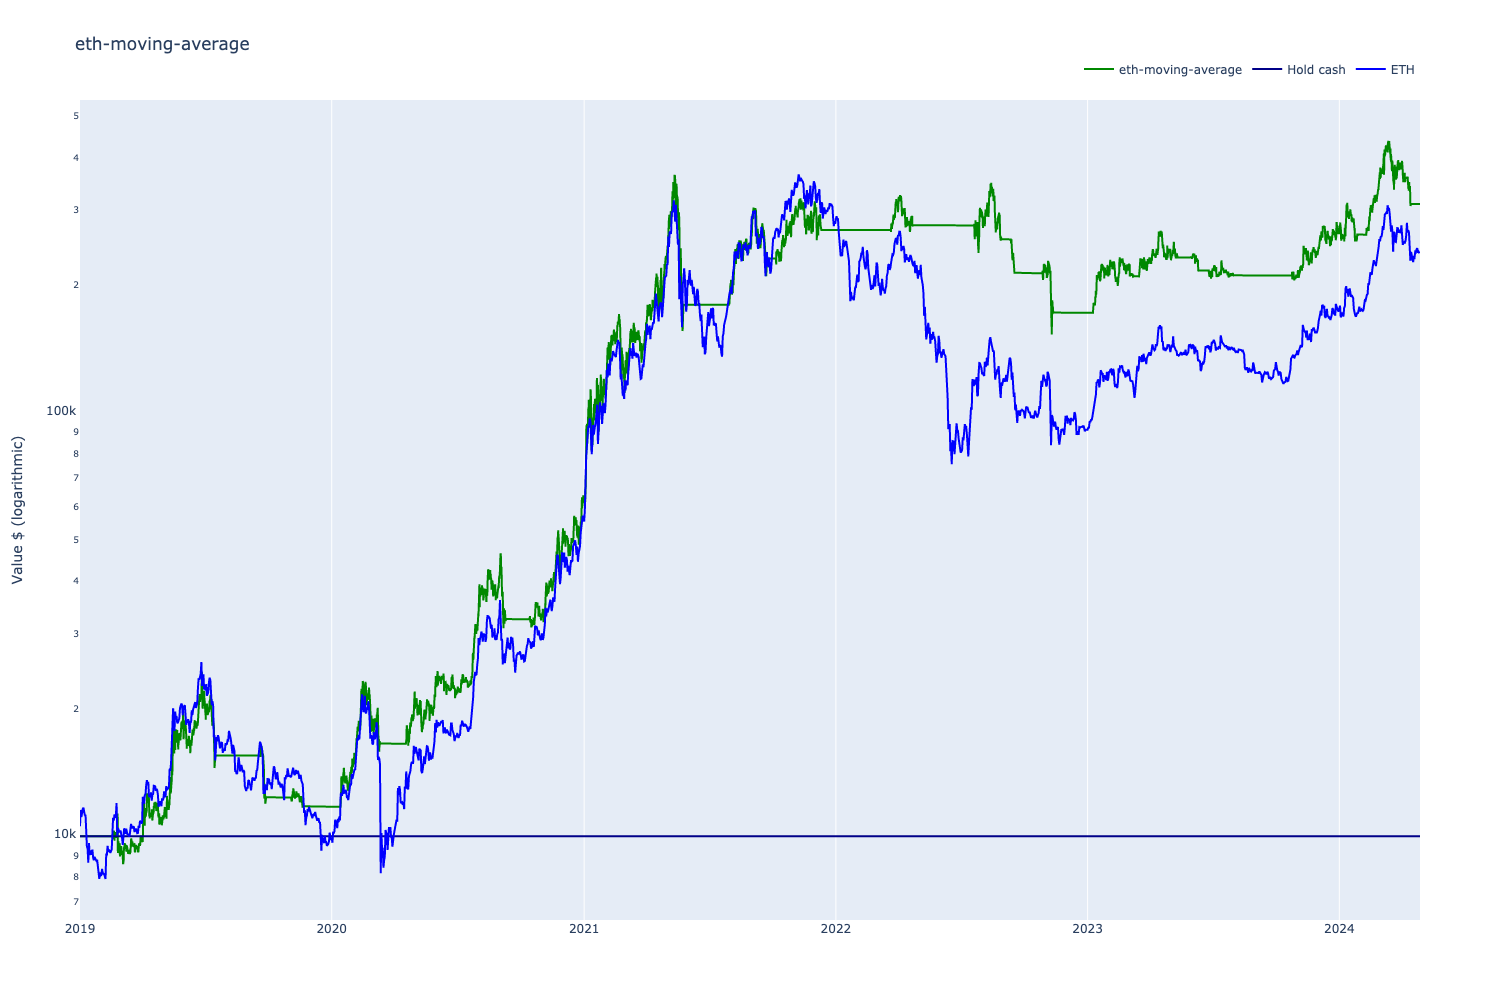

In [30]:
import pandas as pd
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=state.portfolio.get_initial_cash()
)

fig = visualise_equity_curve_benchmark(
    name=state.name,
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_cash(),
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=True,
)

fig.show()

# Technical indicator and trade visualisation

- Draw the technical indicators we filled in in `decide_trades()`
- Show the made trades on the price chart for a single trading pair
- You need to zoom in to see the bollinger bands, as the default chart width is full multi-year study.
  However the default notebook chart mode is static images, as interactive images are a bit slow on Github Codespaces.

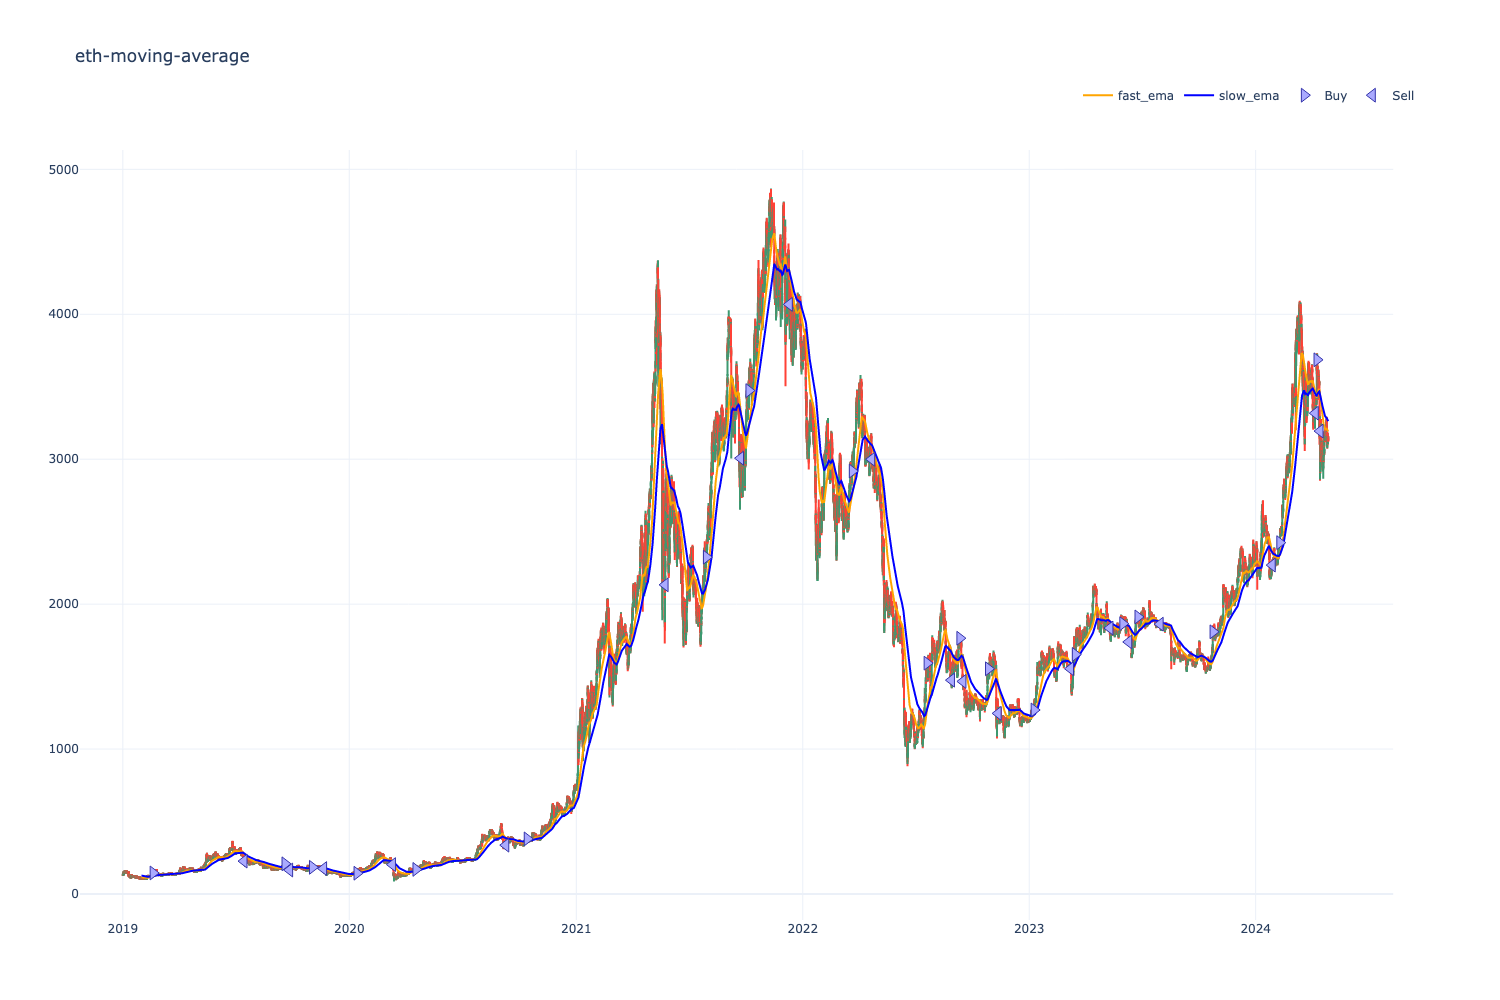

In [25]:
from tradeexecutor.visual.single_pair import visualise_single_pair
from tradingstrategy.charting.candle_chart import VolumeBarMode

start_at, end_at = state.get_strategy_start_and_end()   # Limit chart to our backtesting range

figure = visualise_single_pair(
    state,
    execution_context=notebook_execution_context,
    candle_universe=strategy_universe.data_universe.candles,
    start_at=start_at,
    end_at=end_at,
    volume_bar_mode=VolumeBarMode.hidden,
    volume_axis_name="Volume (USD)",
    height = 1000,
)

# figure.show(renderer='notebook_connected') # for interactive mode
figure.show()

# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold eth using the same initial capital

In [29]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

compare_strategy_backtest_to_multiple_assets(
    state,
    strategy_universe,
    display=True,
)

Strategy         ETH
Start Period             2019-01-01  2019-01-01
End Period               2024-04-26  2024-04-26
Risk-Free Rate                 0.0%        0.0%
Time in Market                59.0%      100.0%
Cumulative Return         3,005.28%   2,151.11%
CAGR﹪                        90.74%      79.55%
Sharpe                         1.35        1.12
Prob. Sharpe Ratio           99.91%      99.46%
Sortino                        2.05        1.64
Sortino/√2                     1.45        1.16
Omega                           1.3         1.3
Max Drawdown                -56.48%      -79.3%
Longest DD Days                1021         899
Gain/Pain Ratio                 0.3        0.19
Gain/Pain (1M)                  2.1        1.34
Payoff Ratio                   1.14        1.16
Profit Factor                   1.3        1.19
Common Sense Ratio             1.65        1.33
CPC Index                      0.79        0.71
Tail Ratio                     1.26        1.12
Outlier Win Ratio              7.56        3.53
Outlier Loss Ratio             3.57        3.83
MTD                         -20.53%      -14.1%
3M                           20.58%      41.14%
6M                           48.83%      75.21%
YTD                           17.8%      37.23%
1Y                            31.5%       67.8%
3Y (ann.)                    20.64%       5.14%
5Y (ann.)                    79.98%      67.07%
10Y (ann.)                   90.74%      79.55%
All-time (ann.)              90.74%      79.55%
Avg. Drawdown               -10.29%     -13.66%
Avg. Drawdown Days               39          46
Recovery Factor               53.21       27.13
Ulcer Index                     0.3        0.46
Serenity Index                 6.55        2.72
Annualised return (raw)    0.907398         NaN

# Trading statistics

- Display summare about made trades

In [27]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())

# Rolling Sharpe

- See how the six months rolling Sharpe ratio changes over time

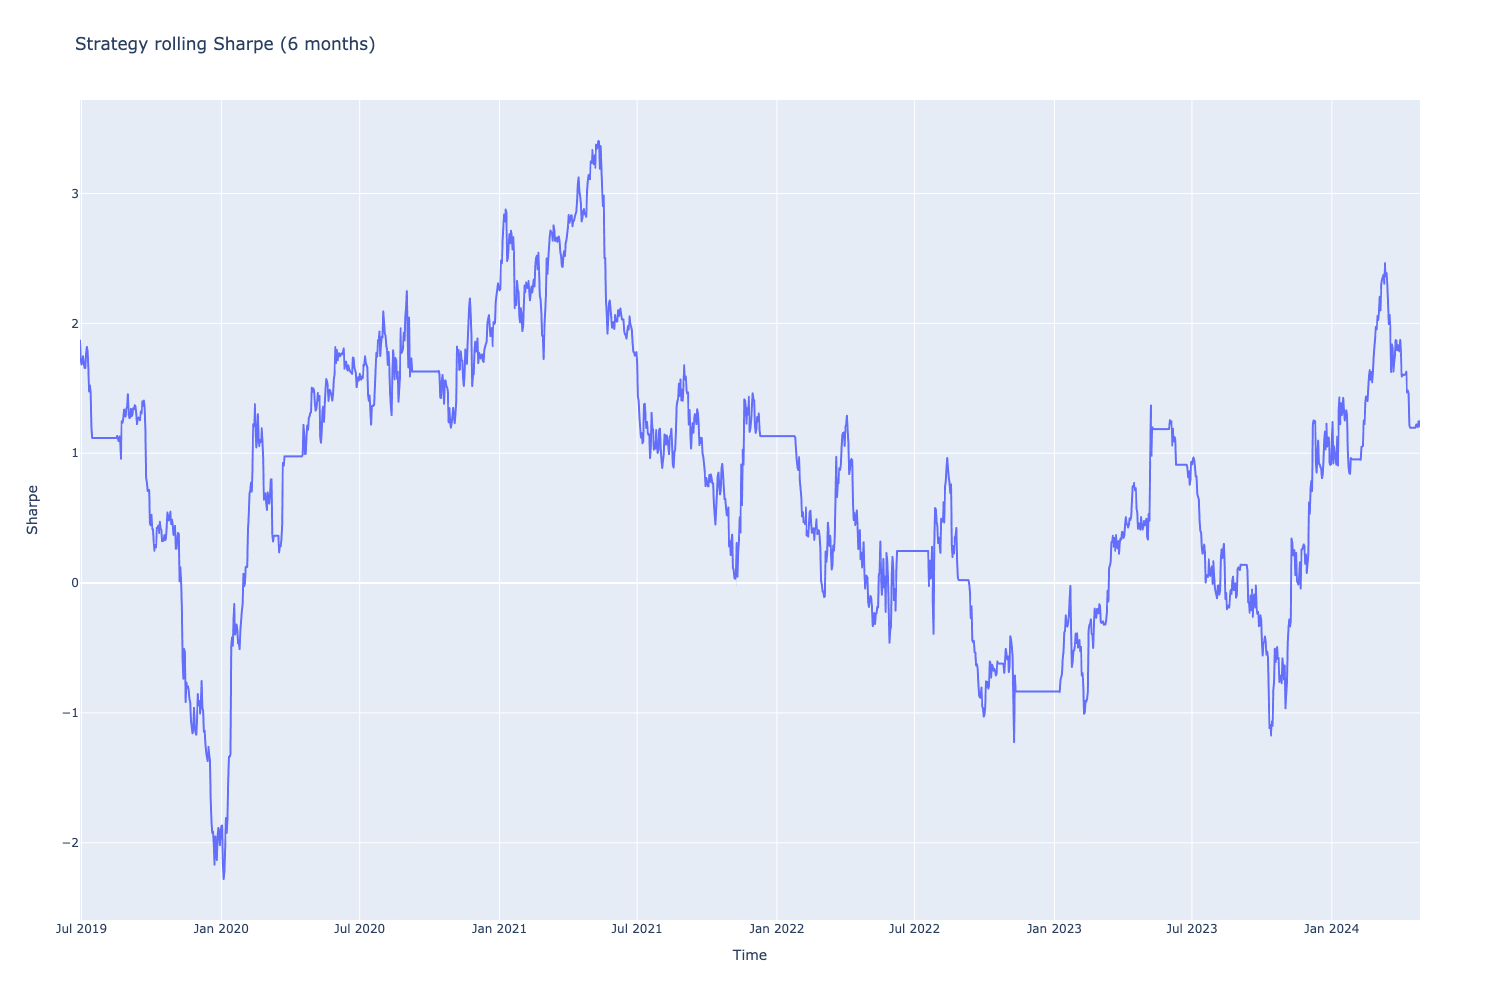

In [28]:
import plotly.express as px

from tradeexecutor.visual.equity_curve import calculate_rolling_sharpe

rolling_sharpe = calculate_rolling_sharpe(
    returns,
    freq="D",
    periods=180,
)

fig = px.line(rolling_sharpe, title='Strategy rolling Sharpe (6 months)')
fig.update_layout(showlegend=False)
fig.update_yaxes(title="Sharpe")
fig.update_xaxes(title="Time")
fig.show()